# Model Definition

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# Define the Pose Estimation Model
class PoseEstimationNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(PoseEstimationNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, output_size)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

class ObjectDatasetByID(Dataset):
    def __init__(self, data_2d_path, data_3d_path):
        self.data_by_id = defaultdict(lambda: {"2d": [], "3d": []})
        self.expected_output_size = 31  # Expected output size based on structure

        files_2d = sorted([f for f in os.listdir(data_2d_path) if f.endswith('.csv')])
        
        for file_2d in files_2d:
            data_2d_file_path = os.path.join(data_2d_path, file_2d)
            data_3d_file_path = os.path.join(data_3d_path, file_2d)

            if not os.path.exists(data_3d_file_path):
                print(f"Skipping; 3D file missing for: {file_2d}")
                continue

            try:
                df_2d = pd.read_csv(data_2d_file_path, header=None)
                df_3d = pd.read_csv(data_3d_file_path, header=None)

                if len(df_2d) != len(df_3d):
                    print(f"Skipping; row count mismatch in files: {file_2d}")
                    continue
                if df_3d.shape[1] != self.expected_output_size:
                    print(f"Skipping; 3D data size mismatch for file {file_2d}")
                    continue

                for row_2d, row_3d in zip(df_2d.values, df_3d.values):
                    obj_id = int(row_2d[0])  # First column is the ID
                    self.data_by_id[obj_id]["2d"].append(torch.tensor(row_2d[1:], dtype=torch.float32)) 
                    self.data_by_id[obj_id]["3d"].append(torch.tensor(row_3d[1:], dtype=torch.float32))

            except (pd.errors.EmptyDataError, ValueError):
                print(f"Skipping invalid file pair: {file_2d}")

    def get_data_by_id(self):
        # Returns the data separated by ID
        return {obj_id: (torch.stack(data["2d"]), torch.stack(data["3d"]))
                for obj_id, data in self.data_by_id.items()}


# Functions for Training

In [2]:
# Evaluation function
def evaluate_model(model, data_loader, criterion, device='cpu'):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
    return running_loss / len(data_loader)

# Training function with early stopping
def train_model_for_id(
    model, train_loader, val_loader, criterion, optimizer, 
    num_epochs=10, patience=5, device='cpu', obj_id=None
):
    model.to(device)
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    print(f"\n{'='*50}")
    print(f"Training Start for ID {obj_id}")
    print(f"{'='*50}\n")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            # Handle single-sample batches
            if inputs.size(0) < 2:
                print("Switching to eval mode for single-sample batch.")
                model.eval()  # Use eval mode for BatchNorm1d
                with torch.no_grad():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                model.train()  # Switch back to train mode
                continue

            # Normal training process for batches with sufficient samples
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_loss = running_loss / len(train_loader)
        val_loss = evaluate_model(model, val_loader, criterion, device)

        print(f"ID: {obj_id} - Epoch [{epoch+1}/{num_epochs}] - "
              f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Early stopping and model saving logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), f"sye{obj_id}.pth")
            print(f"Validation loss improved. Model for ID {obj_id} saved.")
        else:
            epochs_without_improvement += 1
            print(f"No improvement for {epochs_without_improvement} epochs.")

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered for ID {obj_id} after {epoch+1} epochs.")
            break


# Training

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset

base_path = "C:\\Users\\sakar\\OneDrive\\mt-datas\\synthetic_data"
dataset_name = "12_yoro_dataset"
data_2d_subfolder = "2d_data"
data_3d_subfolder = "3d_data"

# Construct paths to the data directories
data_2d_path = os.path.join(base_path, dataset_name, data_2d_subfolder)
data_3d_path = os.path.join(base_path, dataset_name, data_3d_subfolder)

# Load the dataset and get data by ID
object_dataset_by_id = ObjectDatasetByID(data_2d_path, data_3d_path)
data_by_id = object_dataset_by_id.get_data_by_id()

# Model parameters
input_size = 20
output_size = 30
learning_rate = 0.001
num_epochs = 50
patience = 10  # Early stopping patience
test_size = 100

# Loss function
criterion = nn.MSELoss()

# Variable to store test datasets
test_data_by_id = {}

# Loop through each unique ID to train and save models
for obj_id, (data_2d, data_3d) in data_by_id.items():
    if len(data_2d) < test_size:
        print(f"Skipping ID {obj_id} due to insufficient data.")
        continue

    # Reserve the last x points for the test set
    test_data_2d = data_2d[-test_size:]
    test_data_3d = data_3d[-test_size:]
    test_data_by_id[obj_id] = (test_data_2d, test_data_3d)

    # Use the remaining data for training and validation
    remaining_data_2d = data_2d[:-test_size]
    remaining_data_3d = data_3d[:-test_size]
    dataset = TensorDataset(remaining_data_2d, remaining_data_3d)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    if train_size == 0 or val_size == 0:
        print(f"Skipping ID {obj_id} due to insufficient data after split.")
        continue

    # Split into training and validation datasets
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Initialize the model
    model = PoseEstimationNet(input_size=input_size, output_size=output_size)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"\nStarting training for ID {obj_id}")
    train_model_for_id(
        model, train_loader, val_loader, criterion, optimizer, 
        num_epochs=num_epochs, patience=patience, device='cpu', obj_id=obj_id
    )

# Inference

In [4]:
import torch
import pandas as pd
import os

base_path = r"C:\Users\sakar\OneDrive\mt-datas\yolo\pose_estimation"
filename = "1_realistic_chair_train_2_yolo_result.csv"

# Construct paths to the data directories
data_2d_sample_path = os.path.join(base_path, filename)

# Define the function to load the trained model and use it for inference
def load_model_and_predict_3d(data_2d_path, model_path="sye0.pth", input_size=20, output_size=30):
    # Instantiate the model architecture and load weights
    model = PoseEstimationNet(input_size=input_size, output_size=output_size)
    model.load_state_dict(torch.load(model_path, weights_only=True))  # Added `weights_only=True`
    model.eval()  # Set the model to evaluation mode

    # Load the 2D data for inference
    try:
        df_2d = pd.read_csv(data_2d_path, header=None)
        df_2d = df_2d.iloc[:, 1:]  # Drop the ID column
        data_2d_tensor = torch.tensor(df_2d.values, dtype=torch.float32)
    except Exception as e:
        print(f"Error loading or processing 2D data: {e}")
        return None

    # Run the model to predict 3D points
    with torch.no_grad():
        predictions_3d = model(data_2d_tensor)
    
    print(predictions_3d)
    return predictions_3d

predictions_3d = load_model_and_predict_3d(data_2d_sample_path)

tensor([[ 3.1048e-01, -5.7167e-01,  2.5734e+00,  4.7772e-02,  7.2864e+01,
          1.6635e-03,  4.1837e-01, -4.7158e-01,  2.5764e+00,  3.1399e-01,
         -4.7160e-01,  2.4687e+00,  2.0193e-01, -4.7162e-01,  2.5698e+00,
          3.0651e-01, -4.7163e-01,  2.6776e+00,  4.1768e-01, -6.7176e-01,
          2.5761e+00,  3.1414e-01, -6.7175e-01,  2.4686e+00,  2.0208e-01,
         -6.7176e-01,  2.5699e+00,  3.0620e-01, -6.7178e-01,  2.6778e+00],
        [ 5.2560e-01, -3.2461e-01,  3.2602e+00,  1.5463e-02,  1.2864e+02,
          2.1816e-02,  5.1698e-01, -2.2466e-01,  3.2059e+00,  4.6768e-01,
         -2.2465e-01,  3.2637e+00,  5.3411e-01, -2.2464e-01,  3.3131e+00,
          5.8341e-01, -2.2463e-01,  3.2550e+00,  5.1733e-01, -4.2457e-01,
          3.2060e+00,  4.6760e-01, -4.2457e-01,  3.2638e+00,  5.3403e-01,
         -4.2457e-01,  3.3131e+00,  5.8357e-01, -4.2456e-01,  3.2549e+00]])


# Testing the Shape

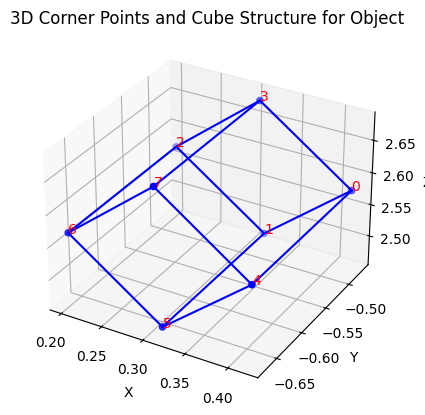

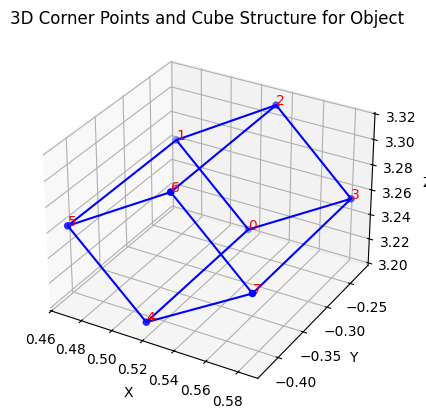

In [5]:
import matplotlib.pyplot as plt

# Function to plot 3D corner points from predictions and connect them to form a cube
def plot_3d_corners(predictions_3d):
    # Check if predictions are available
    if predictions_3d is None:
        print("No predictions to plot.")
        return
    
    # Extract the last 24 elements for the 8 corner points (each corner has 3 coordinates)
    corner_predictions = predictions_3d[:, -24:].view(-1, 8, 3)

    # Plot each object’s corners in a 3D space
    for i, corners in enumerate(corner_predictions):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        # Coordinates of the corners
        x, y, z = corners[:, 0], corners[:, 1], corners[:, 2]
        ax.scatter(x, y, z, c='b', marker='o')

        # Annotate each corner for clarity
        for j, (x_coord, y_coord, z_coord) in enumerate(corners):
            ax.text(x_coord, y_coord, z_coord, f"{j}", color="red")

        # Define connections for the cube
        connections = [
            (0, 1), (1, 2), (2, 3), (3, 0),  # Bottom square
            (4, 5), (5, 6), (6, 7), (7, 4),  # Top square
            (0, 4), (1, 5), (2, 6), (3, 7)   # Vertical edges connecting squares
        ]

        # Plot lines for each connection
        for start, end in connections:
            ax.plot(
                [x[start], x[end]],
                [y[start], y[end]],
                [z[start], z[end]],
                'b-'
            )

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.title(f"3D Corner Points and Cube Structure for Object")
        plt.show()

# Plot the 3D corners from the predictions
plot_3d_corners(predictions_3d)


# Results and Measurements

In [6]:
import os
import pandas as pd

# Inference for measurements
def load_model_and_predict_3d(data_2d_path, input_size=20, output_size=30):
    """
    Predict 3D data from 2D data using object-specific models.
    Returns a DataFrame with predictions.
    """
    try:
        # Load the 2D data
        df_2d = pd.read_csv(data_2d_path, header=None)

        # Prepare the output DataFrame
        all_predictions = []

        # Process each row independently
        for _, row in df_2d.iterrows():
            object_id = int(row.iloc[0])  # Extract the object ID from the first column
            model_path = f"C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye{object_id}.pth"
            if not os.path.exists(model_path):
                print(f"Model file not found for object ID {object_id}: {model_path}")
                continue

            print(f"Using model for object ID {object_id}: {model_path}")

            # Prepare the data for inference: Drop the ID column
            data_2d_tensor = torch.tensor(row.iloc[1:].values.reshape(1, -1), dtype=torch.float32)

            # Validate input dimensions
            if data_2d_tensor.shape[1] != input_size:
                print(f"Error: Model expects input size {input_size}, but got {data_2d_tensor.shape[1]} for object ID {object_id}")
                continue

            # Instantiate the model architecture and load weights
            model = PoseEstimationNet(input_size=input_size, output_size=output_size)
            model.load_state_dict(torch.load(model_path))
            model.eval()  # Set the model to evaluation mode

            # Run the model to predict 3D points
            with torch.no_grad():
                try:
                    predictions_3d = model(data_2d_tensor)
                except Exception as e:
                    print(f"Error during model inference for object ID {object_id}: {e}")
                    continue

            # Convert predictions to a list
            predictions = predictions_3d.numpy().flatten().tolist()

            # Add the object ID back to the predictions
            all_predictions.append([object_id] + predictions)

        # Convert predictions to DataFrame
        predictions_df = pd.DataFrame(all_predictions)

        return predictions_df

    except Exception as e:
        print(f"Error during 3D prediction: {e}")
        return pd.DataFrame()

In [8]:
base_path_2d = r"C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\2d_data"
base_path_3d = r"C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\3d_data"
save_dir = r"C:\Users\sakar\OneDrive\mt-datas\Assets for the Report\Results Test"
dataset = "test"
starting_index = 10000
max_files = 100 

# Euclidean Distance and Rotation Difference

In [10]:
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean

def compute_euclidean_distance_3d(pred_row, gt_row):
    """
    Computes the Euclidean distance between 3D positions of predictions and ground truth.
    """
    pred_position = pred_row[:3]
    gt_position = gt_row[:3]
    return euclidean(pred_position, gt_position)


def compute_corner_distances(pred_row, gt_row):
    """
    Computes average Euclidean distance between corners of predicted and ground truth bounding boxes.
    """
    try:
        pred_corners = np.array(pred_row[6:]).reshape(-1, 3)
        gt_corners = np.array(gt_row[6:]).reshape(-1, 3)

        if len(pred_corners) != len(gt_corners):
            print("Mismatch in the number of corners. Skipping this comparison.")
            return np.nan

        distances = [euclidean(pred_corners[i], gt_corners[i]) for i in range(len(pred_corners))]
        return np.mean(distances)
    except ValueError as e:
        print(f"Error in computing corner distances: {e}")
        return np.nan


def find_closest_match_3d(predictions, ground_truth):
    """
    Finds the closest match for each prediction in the ground truth based on Euclidean distance.
    Adds rotation y difference to the results.
    """
    results = []

    if predictions.empty or ground_truth.empty:
        print("One of the DataFrames is empty, skipping...")
        return results

    gt_groups = ground_truth.groupby(0)
    pred_groups = predictions.groupby(0)

    # Get the intersection of IDs present in both predictions and ground truth
    common_ids = set(gt_groups.groups.keys()) & set(pred_groups.groups.keys())

    for obj_id in common_ids:
        gt_rows = ground_truth.loc[gt_groups.groups[obj_id]].copy()
        pred_rows = predictions.loc[pred_groups.groups[obj_id]].copy()

        # Match predictions and ground truth for this object ID
        while not gt_rows.empty and not pred_rows.empty:
            min_distance = None
            min_corner_distance = None
            min_rotation_y_diff = None
            min_gt_index = None
            min_pred_index = None

            for gt_index, gt_row in gt_rows.iterrows():
                for pred_index, pred_row in pred_rows.iterrows():
                    position_distance = compute_euclidean_distance_3d(pred_row[1:], gt_row[1:])
                    corner_distance = compute_corner_distances(pred_row[1:], gt_row[1:])
                    rotation_y_diff = abs(pred_row[5] - gt_row[5])  # Rotation y is at index 4

                    if min_distance is None or position_distance < min_distance:
                        min_distance = position_distance
                        min_corner_distance = corner_distance
                        min_rotation_y_diff = rotation_y_diff
                        min_gt_index = gt_index
                        min_pred_index = pred_index

            results.append({
                "id": obj_id,
                "min_position_distance": min_distance,
                "min_corner_distance": min_corner_distance,
                "rotation_y_difference": min_rotation_y_diff,
            })

            gt_rows.drop(index=min_gt_index, inplace=True)
            pred_rows.drop(index=min_pred_index, inplace=True)

    return results


def process_all_files_3d(base_path_2d, base_path_3d, start_index=0, max_files=100):
    """
    Process 2D files to predict 3D data and compare with ground truth 3D data.
    Allows starting from a specific index and limiting the number of files processed.
    """
    def extract_numeric(file_name):
        # Extract the numeric part of the file name before ".csv"
        return int(os.path.splitext(file_name)[0])
    
    # List and sort files numerically
    file_list = sorted(
        [file_name for file_name in os.listdir(base_path_2d) if file_name.endswith(".csv")],
        key=extract_numeric
    )

    # Apply start_index and limit processing to max_files
    file_list = file_list[start_index:start_index + max_files]
    total_files = len(file_list)

    all_results = []

    for idx, file_name in enumerate(file_list):
        print(f"Processing file {idx + 1}/{total_files} ({((idx + 1) / total_files) * 100:.2f}%) - {file_name}")

        file_2d_path = os.path.join(base_path_2d, file_name)
        file_3d_path = os.path.join(base_path_3d, file_name)

        # Skip if ground truth is missing
        if not os.path.exists(file_3d_path):
            print(f"Ground truth file for {file_name} not found. Skipping.")
            continue

        # Predict 3D points from 2D data
        predicted_3d_df = load_model_and_predict_3d(file_2d_path)
        if predicted_3d_df.empty:
            print(f"Prediction failed for {file_name}. Skipping.")
            continue

        try:
            # Load ground truth
            actual_3d_df = pd.read_csv(file_3d_path, header=None)

            # Check for correct number of columns
            if actual_3d_df.shape[1] < 31:
                print(f"Incorrect ground truth format for {file_name}. Expected 31 columns, got {actual_3d_df.shape[1]}. Skipping.")
                continue

            # Find closest matches
            results = find_closest_match_3d(predicted_3d_df, actual_3d_df)

            # Store results for the file
            file_results = {"file": file_name, "objects": results}
            all_results.append(file_results)

        except Exception as e:
            print(f"Error processing file {file_name}: {e}")
            continue

    return all_results

# Example usage
results = process_all_files_3d(base_path_2d, base_path_3d, start_index=starting_index, max_files=max_files)

# Example output
print("Euclidean Distance Results:")
for file_result in results:
    print(file_result)


Processing file 1/100 (1.00%) - 10000.csv
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 7: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye7.pth
Using model for object ID 2: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye2.pth
Processing file 2/100 (2.00%) - 10001.csv
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0:

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 2: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye2.pth
Processing file 4/100 (4.00%) - 10003.csv
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 7: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye7.pth
Using model for object ID 2: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye2.pth
Processing file 5/100 (5.00%) - 10004.csv
Using model for object ID 1: C:/

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Using model for object ID 1: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye1.pth
Using model for object ID 9: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye9.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Processing file 7/100 (7.00%) - 10006.csv
Using model for object ID 1: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye1.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/li

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Using model for object ID 9: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye9.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 10: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye10.pth
Processing file 10/100 (10.00%) - 10009.csv
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 9: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye9.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-vi

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 10: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye10.pth
Processing file 12/100 (12.00%) - 10011.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-vide

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Processing file 15/100 (15.00%) - 10014.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth
Processing file 16/100 (16.00%) - 10015.csv
Using model for object ID 1: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye1.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Processing file 17/100 (17.00%) - 10016.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_mo

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Processing file 18/100 (18.00%) - 10017.csv
Using model for object ID 1: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye1.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 10: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye10.pth
Using model for object ID 6: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye6.pth
Processing file 19/100 (19.00%) - 10018.csv
Using model for object ID 1: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye1.pth
Using model for object ID 0:

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Processing file 20/100 (20.00%) - 10019.csv
Using model for object ID 1: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye1.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 10: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye10.pth
Processing file 21/100 (21.00%) - 10020.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0:

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Processing file 23/100 (23.00%) - 10022.csv
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 10: C:/Users/sakar/mt-3d-environments-from-vid

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Processing file 25/100 (25.00%) - 10024.csv
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 8: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye8.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth
Using model for object ID 6: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye6.pth
Using model for object ID 7: C:/Users/sakar/mt-3d-environments-from-vide

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Using model for object ID 6: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye6.pth
Using model for object ID 7: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye7.pth
Using model for object ID 7: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye7.pth
Processing file 27/100 (27.00%) - 10026.csv
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-vi

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Using model for object ID 7: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye7.pth
Using model for object ID 6: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye6.pth
Using model for object ID 7: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye7.pth
Using model for object ID 7: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye7.pth
Processing file 28/100 (28.00%) - 10027.csv
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-vide

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Processing file 29/100 (29.00%) - 10028.csv
Using model for object ID 1: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye1.pth
Using model for object ID 9: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye9.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 2: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye2.pth
Processing file 30/100 (30.00%) - 10029.csv
Using model for object ID 1: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye1.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Processing file 32/100 (32.00%) - 10031.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 2: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye2.pth
Processing file 33/100 (33.00%) - 10032.csv
Using model for object ID 9: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye9.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Processing file 34/100 (34.00%) - 10033.csv
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 8: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye8.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth
Using model for object ID 10: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye10.pth
Using model for object ID 7: C:/Users/sakar/mt-3d-environments-from-

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Processing file 36/100 (36.00%) - 10035.csv
Using model for object ID 9: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye9.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 8: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye8.pth
Using model for object ID 10: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye10.pth
Using model for object ID 7: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye7.pth
Using model for object ID 6: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye6.pth
Processing file 37/100 (37.00%) - 10036.csv
Using model for object ID 9:

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 7: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye7.pth
Using model for object ID 2: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye2.pth
Processing file 38/100 (38.00%) - 10037.csv
Using model for object ID 9: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye9.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 7: C:/Users/sakar/mt-3d-environments-from-video/

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 2: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye2.pth
Processing file 40/100 (40.00%) - 10039.csv
Using model for object ID 9: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye9.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Processing file 41/100 (41.00%) - 10040.csv
Using model for object ID 1: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye1.pth
Using model for object ID 9: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye9.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Processing file 42/100 (42.00%) - 10041.csv
Using model for object ID 1: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye1.pth
Using model for object ID 9: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye9.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Processing file 43/100 (43.00%) - 10042.csv
Using model for object ID 1: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye1.pth
Using model for object ID 9: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye9.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Processing file 44/100 (44.00%) - 10043.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth
Processing file 45/100 (45.00%

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 2: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye2.pth
Using model for object ID 2: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye2.pth
Processing file 47/100 (47.00%) - 10046.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 2: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye2.pth


C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Processing file 48/100 (48.00%) - 10047.csv
Using model for object ID 9: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye9.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Processing file 49/100 (49.00%) - 10048.csv
Using model for object ID 1: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye1.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Processing file 51/100 (51.00%) - 10050.csv
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 9: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye9.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth
Processing file 52/100 (52.00%) - 10051.csv
Using model for object ID 9: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye9.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0:

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Processing file 55/100 (55.00%) - 10054.csv
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 2: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye2.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth
Using model for object ID 7: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye7.pth
Using model for object ID 7: C:/Users/sakar/mt-3d-environments-from-vi

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Using model for object ID 2: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye2.pth
Using model for object ID 7: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye7.pth
Processing file 57/100 (57.00%) - 10056.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth


C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Processing file 58/100 (58.00%) - 10057.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth
Using model for object ID 5: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye5.pth
Processing file 59/100 (59.00%) - 10058.csv
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0:

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth
Using model for object ID 5: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye5.pth
Processing file 61/100 (61.00%) - 10060.csv
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 9: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye9.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-vi

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 7: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye7.pth
Processing file 63/100 (63.00%) - 10062.csv
Using model for object ID 9: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye9.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Processing file 64/100 (64.00%) - 10063.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Processing file 65/100 (65.00%) - 10064.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 6: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye6.pth
Processing file 66/100 (66.00%) - 10065.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Using model for object ID 2: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye2.pth
Using model for object ID 8: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye8.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth
Using model for object ID 6: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye6.pth
Processing file 67/100 (67.00%) - 10066.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Processing file 70/100 (70.00%) - 10069.csv
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-vide

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth
Processing file 72/100 (72.00%) - 10071.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth
Processing file 73/100 (73.00%) - 10072.csv
Using model for object ID 9: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye9.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Processing file 74/100 (74.00%) - 10073.csv
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 8: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye8.pth
Using model for object ID 8: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye8.pth
Processing file 75/100 (75.00%) - 10074.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4:

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Processing file 77/100 (77.00%) - 10076.csv
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 1: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye1.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Processing file 78/100 (78.00%) - 10077.csv
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth
Using model for object ID 7: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye7.pth
Processing file 80/100 (80.00%) - 10079.csv
Using model for object ID 9: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye9.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth
Using model for object ID 7: C:/Users/sakar/mt-3d-environments-from-video/

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth
Processing file 84/100 (84.00%) - 10083.csv
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth
Processing file 85/100 (85.00%) - 10084.csv
Using model for object ID 0:

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Processing file 86/100 (86.00%) - 10085.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth
Processing file 87/100 (87.00%) - 10086.csv
Using model for object ID 1: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye1.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Using model for object ID 7: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye7.pth
Processing file 89/100 (89.00%) - 10088.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 10: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye10.pth
Processing file 90/100 (90.00%) - 10089.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0:

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 3: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye3.pth
Using model for object ID 5: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye5.pth
Processing file 95/100 (95.00%) - 10094.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Processing file 97/100 (97.00%) - 10096.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Using model for object ID 2: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye2.pth
Using model for object ID 2: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye2.pth
Processing file 98/100 (98.00%) - 10097.csv
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\saka

Processing file 100/100 (100.00%) - 10099.csv
Using model for object ID 11: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye11.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 0: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye0.pth
Using model for object ID 4: C:/Users/sakar/mt-3d-environments-from-video/lifting_models/sye4.pth
Euclidean Distance Results:
{'file': '10000.csv', 'objects': [{'id': 0, 'min_position_distance': 0.5082493559335924, 'min_corner_distance': np.float64(0.5105372812913451), 'rotation_y_difference': np.float64(51.34761645507814)}, {'id': 0, 'min_position_distance': 0.9885350359538185, 'min_corner_distance': np.float64(0.9896570129996993), 'rotation_y_difference': 

C:\Users\sakar\AppData\Local\Temp\ipykernel_16272\2479106654.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


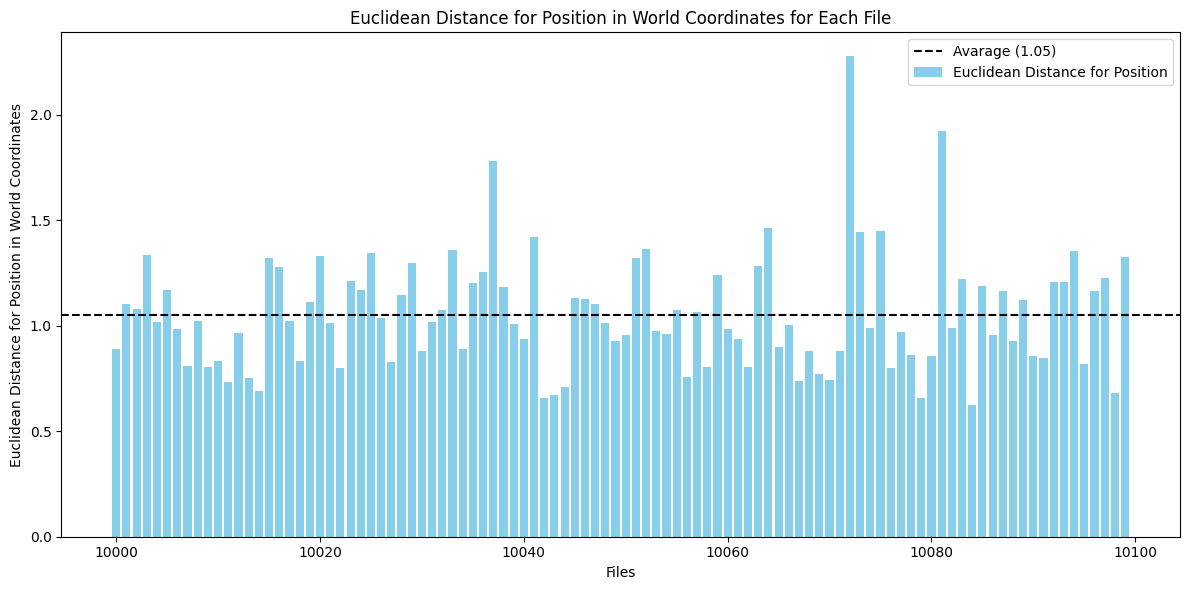

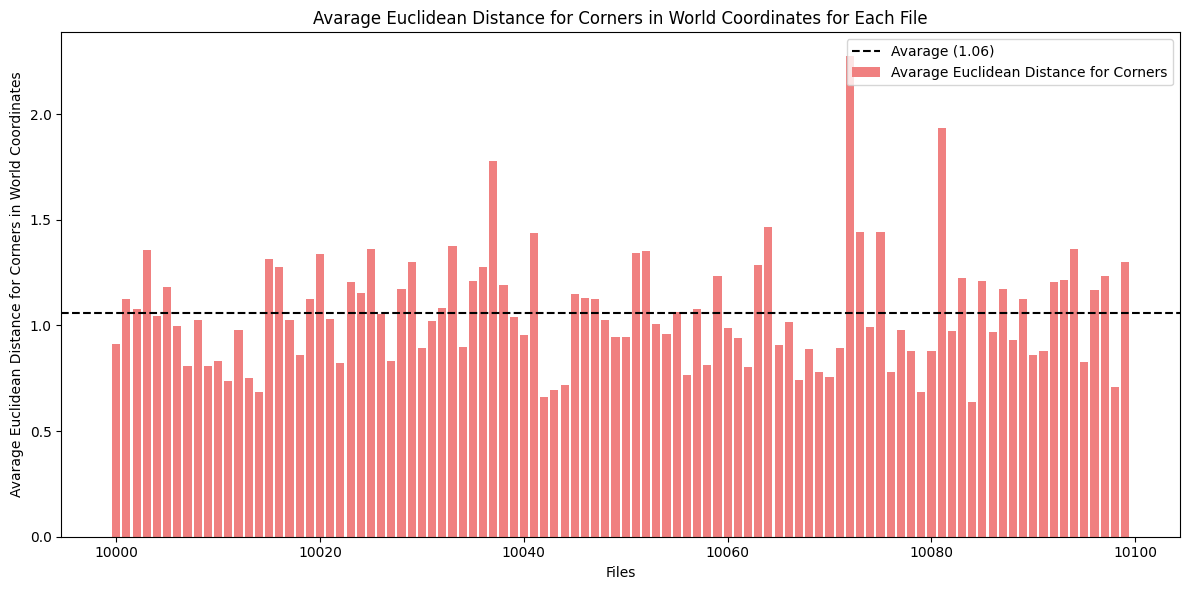

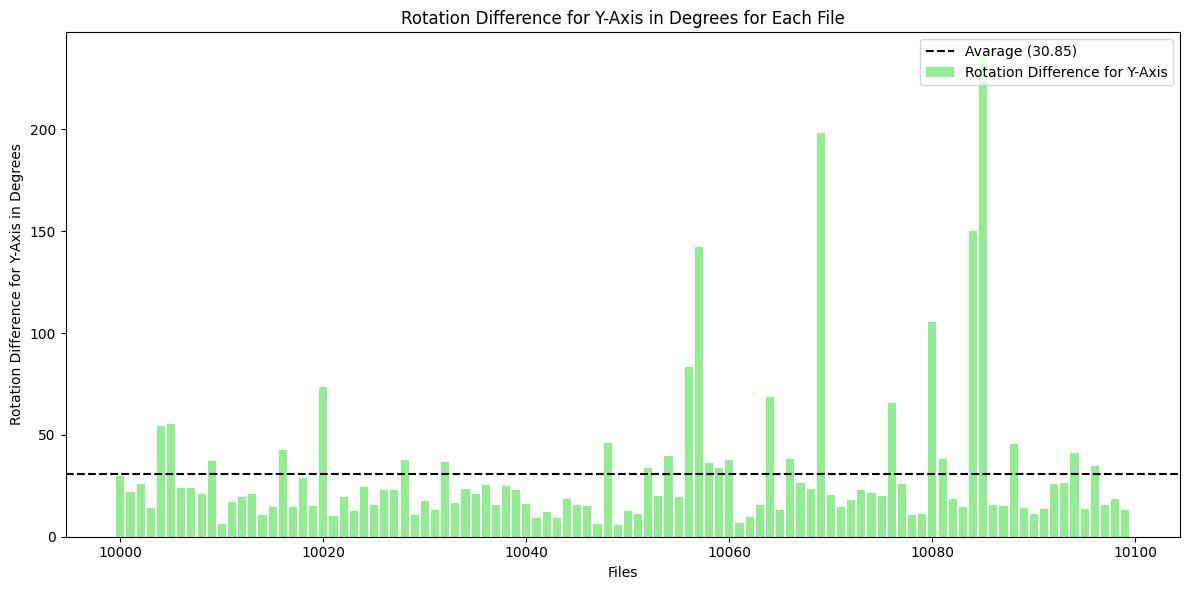

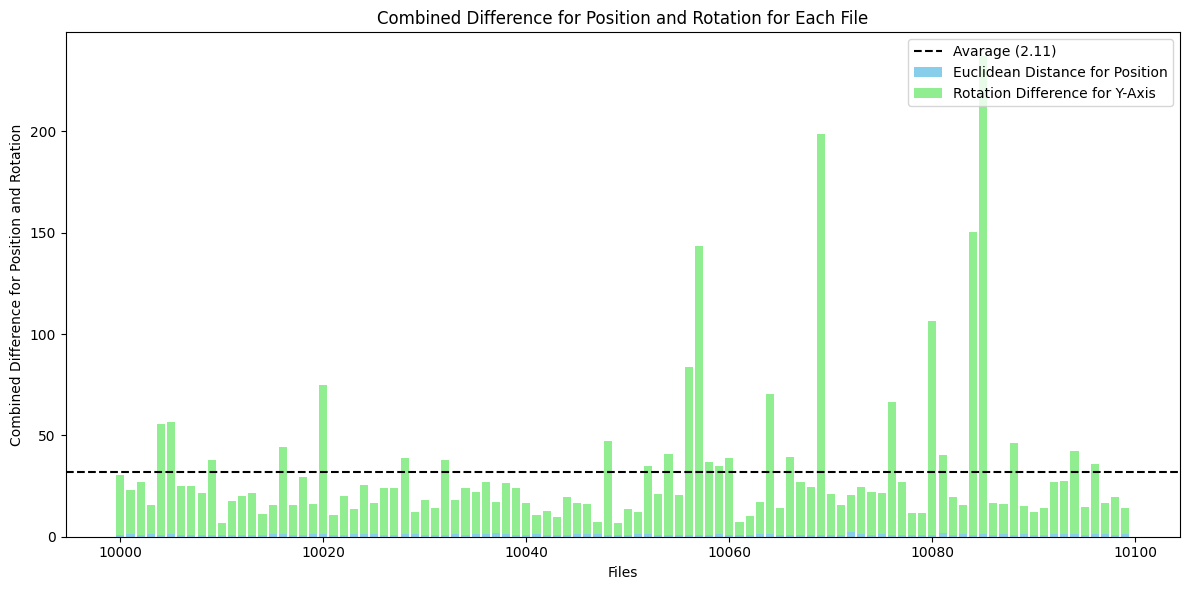

In [15]:
import matplotlib.pyplot as plt
import numpy as np


def generate_3d_distance_plots(results):
    """
    Generate stacked bar plots for position and corner errors.
    Also generate individual plots for position and corner with average lines.
    """
    # Prepare data
    file_names = [result.get("file", "Unknown") for result in results]
    position_distances = [
        np.mean([obj.get("min_position_distance", 0) for obj in result.get("objects", [])]) if result.get("objects") else 0
        for result in results
    ]
    corner_distances = [
        np.mean([obj.get("min_corner_distance", 0) for obj in result.get("objects", [])]) if result.get("objects") else 0
        for result in results
    ]
    rotation_y_differences = [
        np.mean([obj.get("rotation_y_difference", 0) for obj in result.get("objects", [])]) if result.get("objects") else 0
        for result in results
    ]
    
    # Overall averages
    overall_avg_position = np.mean([dist for dist in position_distances if dist > 0])
    overall_avg_corner = np.mean([dist for dist in corner_distances if dist > 0])
    overall_avg_rotation_y = np.mean([diff for diff in rotation_y_differences if diff > 0])
    
    x = np.arange(len(file_names))

    # Individual Plot: Position Distance with Average Line
    plt.figure(figsize=(12, 6))
    plt.bar(x + starting_index, position_distances, color="skyblue", label="Euclidean Distance for Position")
    plt.axhline(overall_avg_position, color="black", linestyle="--", label=f"Avarage ({overall_avg_position:.2f})")
    plt.xlabel("Files")
    plt.ylabel("Euclidean Distance for Position in World Coordinates")
    plt.title("Euclidean Distance for Position in World Coordinates for Each File")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"{save_dir}\\sye_{dataset}_position_distance.png", dpi=300)
    plt.show()

    # Individual Plot: Corner Distance with Average Line
    plt.figure(figsize=(12, 6))
    plt.bar(x + starting_index, corner_distances, color="lightcoral", label="Avarage Euclidean Distance for Corners")
    plt.axhline(overall_avg_corner, color="black", linestyle="--", label=f"Avarage ({overall_avg_corner:.2f})")
    plt.xlabel("Files")
    plt.ylabel("Avarage Euclidean Distance for Corners in World Coordinates")
    plt.title("Avarage Euclidean Distance for Corners in World Coordinates for Each File")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"{save_dir}\\sye_{dataset}_corner_distance.png", dpi=300)
    plt.show()
    
    # Individual Plot: Rotation Y Difference with Average Line
    plt.figure(figsize=(12, 6))
    plt.bar(x + starting_index, rotation_y_differences, color="lightgreen", label="Rotation Difference for Y-Axis")
    plt.axhline(overall_avg_rotation_y, color="black", linestyle="--", label=f"Avarage ({overall_avg_rotation_y:.2f})")
    plt.xlabel("Files")
    plt.ylabel("Rotation Difference for Y-Axis in Degrees")
    plt.title("Rotation Difference for Y-Axis in Degrees for Each File")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"{save_dir}\\sye_{dataset}_rotation_y_difference.png", dpi=300)
    plt.show()

    # Stacked Bar Plot: Position and Corner Errors
    plt.figure(figsize=(12, 6))
    plt.bar(x + starting_index, position_distances, label="Euclidean Distance for Position", color="skyblue")
    plt.bar(x + starting_index, rotation_y_differences, bottom=position_distances, label="Rotation Difference for Y-Axis", color="lightgreen")
    plt.axhline(overall_avg_rotation_y + overall_avg_corner, color="black", linestyle="--", label=f"Avarage ({overall_avg_position + overall_avg_corner:.2f})")
    plt.xlabel("Files")
    plt.ylabel("Combined Difference for Position and Rotation")
    plt.title("Combined Difference for Position and Rotation for Each File")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"{save_dir}\\sye_{dataset}_position_rotation_stacked.png", dpi=300)
    plt.show()

# Generate the plots
generate_3d_distance_plots(results)


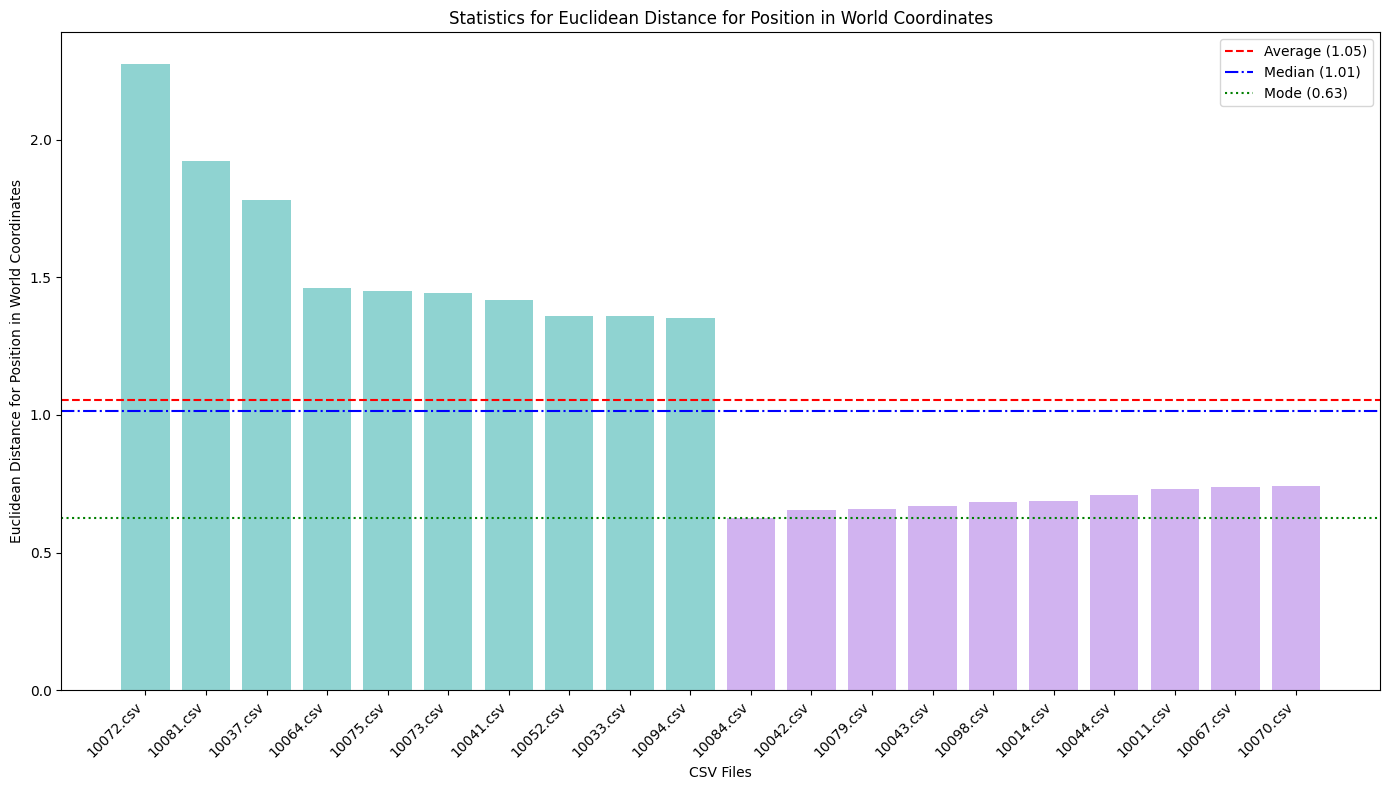

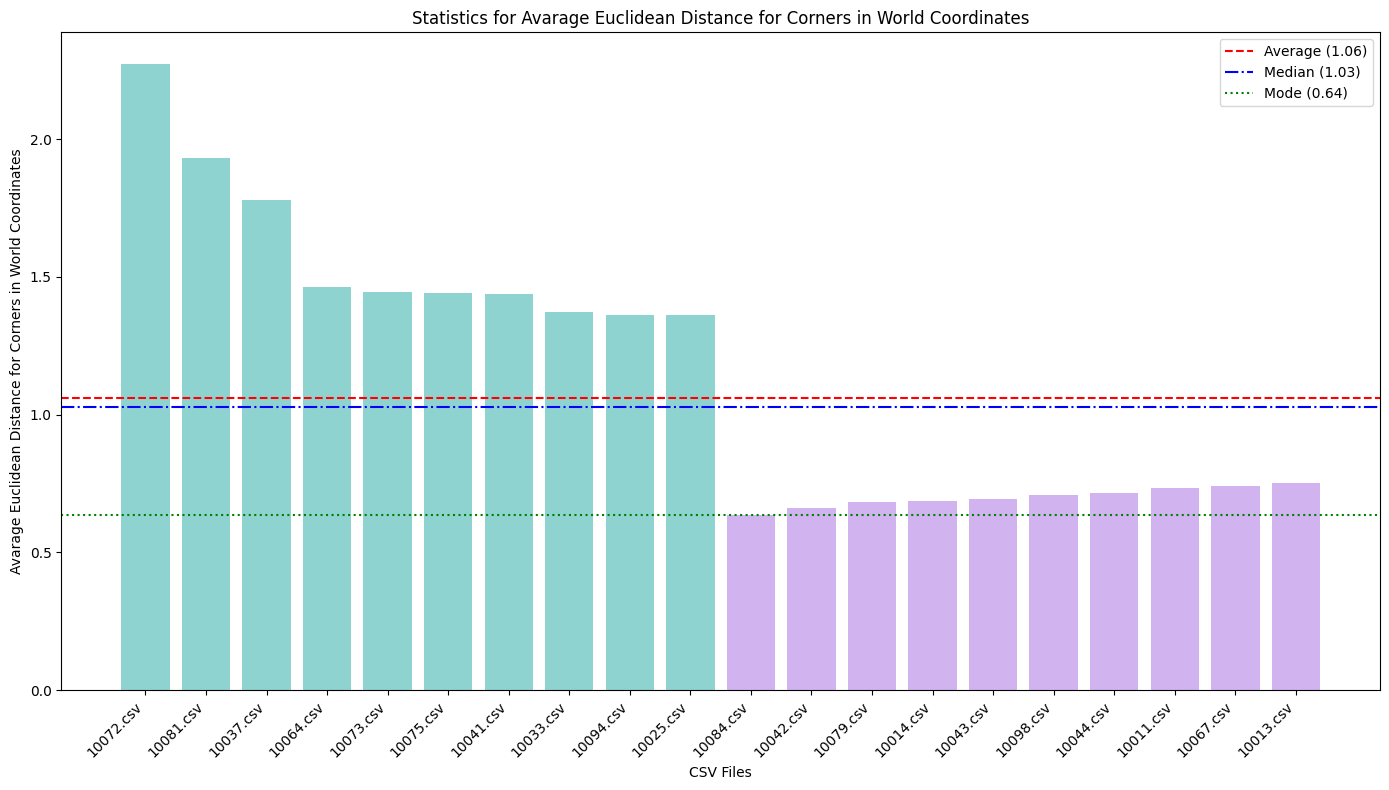

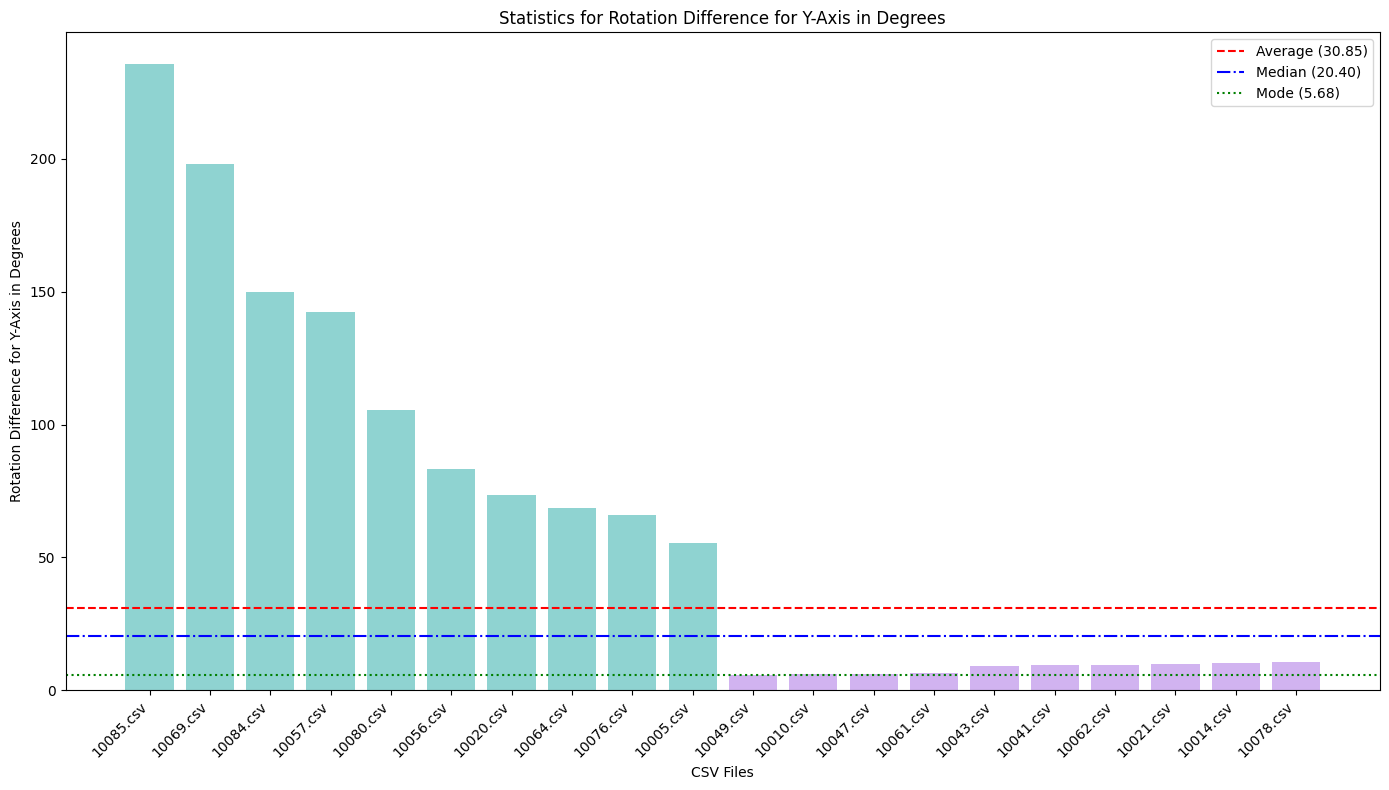

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function to process results into a DataFrame
def process_results(results, metric):
    """
    Convert results into a DataFrame for analysis, focusing on a specific metric.
    """
    data = []
    for file_result in results:
        file_name = file_result["file"]
        avg_metric_value = np.mean([
            obj.get(metric, 0) for obj in file_result["objects"]
        ]) if file_result["objects"] else 0
        data.append({"File": file_name, metric: avg_metric_value})
    return pd.DataFrame(data)

# Function to identify statistics
def identify_statistics(df, metric):
    """
    Identify statistical measures for a specific metric.
    """
    top_10_highest = df.nlargest(10, metric)
    top_10_lowest = df.nsmallest(10, metric)
    median_value = df[metric].median()
    avg_value = df[metric].mean()
    mode_value = df[metric].mode().iloc[0] if not df[metric].mode().empty else None
    return top_10_highest, top_10_lowest, avg_value, median_value, mode_value

# Visualization for min_position_distance
def visualize_min_position_distance(results, save_dir, dataset):
    """
    Visualize statistics for min_position_distance.
    """
    metric = "min_position_distance"
    df = process_results(results, metric)
    top_10_high, top_10_low, avg_value, median_value, mode_value = identify_statistics(df, metric)

    plt.figure(figsize=(14, 8))
    combined = pd.concat([top_10_high, top_10_low])
    labels = combined["File"]
    values = combined[metric]
    colors = ['#8fd3d1'] * len(top_10_high) + ['#d1b3f0'] * len(top_10_low)

    plt.bar(labels, values, color=colors)
    plt.axhline(avg_value, color='red', linestyle='--', label=f'Average ({avg_value:.2f})')
    plt.axhline(median_value, color='blue', linestyle='-.', label=f'Median ({median_value:.2f})')
    if mode_value is not None:
        plt.axhline(mode_value, color='green', linestyle=':', label=f'Mode ({mode_value:.2f})')

    plt.xlabel("CSV Files")
    plt.ylabel("Euclidean Distance for Position in World Coordinates")
    plt.title("Statistics for Euclidean Distance for Position in World Coordinates")
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/sye_{dataset}_{metric.lower()}_statistics.png", dpi=300)
    plt.show()

# Visualization for min_corner_distance
def visualize_min_corner_distance(results, save_dir, dataset):
    """
    Visualize statistics for min_corner_distance.
    """
    metric = "min_corner_distance"
    df = process_results(results, metric)
    top_10_high, top_10_low, avg_value, median_value, mode_value = identify_statistics(df, metric)

    plt.figure(figsize=(14, 8))
    combined = pd.concat([top_10_high, top_10_low])
    labels = combined["File"]
    values = combined[metric]
    colors = ['#8fd3d1'] * len(top_10_high) + ['#d1b3f0'] * len(top_10_low)

    plt.bar(labels, values, color=colors)
    plt.axhline(avg_value, color='red', linestyle='--', label=f'Average ({avg_value:.2f})')
    plt.axhline(median_value, color='blue', linestyle='-.', label=f'Median ({median_value:.2f})')
    if mode_value is not None:
        plt.axhline(mode_value, color='green', linestyle=':', label=f'Mode ({mode_value:.2f})')

    plt.xlabel("CSV Files")
    plt.ylabel("Avarage Euclidean Distance for Corners in World Coordinates")
    plt.title("Statistics for Avarage Euclidean Distance for Corners in World Coordinates")
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/sye_{dataset}_{metric.lower()}_statistics.png", dpi=300)
    plt.show()

# Visualization for rotation_y_difference
def visualize_rotation_y_difference(results, save_dir, dataset):
    """
    Visualize statistics for rotation_y_difference.
    """
    metric = "rotation_y_difference"
    df = process_results(results, metric)
    top_10_high, top_10_low, avg_value, median_value, mode_value = identify_statistics(df, metric)

    plt.figure(figsize=(14, 8))
    combined = pd.concat([top_10_high, top_10_low])
    labels = combined["File"]
    values = combined[metric]
    colors = ['#8fd3d1'] * len(top_10_high) + ['#d1b3f0'] * len(top_10_low)

    plt.bar(labels, values, color=colors)
    plt.axhline(avg_value, color='red', linestyle='--', label=f'Average ({avg_value:.2f})')
    plt.axhline(median_value, color='blue', linestyle='-.', label=f'Median ({median_value:.2f})')
    if mode_value is not None:
        plt.axhline(mode_value, color='green', linestyle=':', label=f'Mode ({mode_value:.2f})')

    plt.xlabel("CSV Files")
    plt.ylabel("Rotation Difference for Y-Axis in Degrees")
    plt.title("Statistics for Rotation Difference for Y-Axis in Degrees")
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/sye_{dataset}_{metric.lower()}_statistics.png", dpi=300)
    plt.show()

# Visualize individual metrics
visualize_min_position_distance(results, save_dir, dataset)
visualize_min_corner_distance(results, save_dir, dataset)
visualize_rotation_y_difference(results, save_dir, dataset)


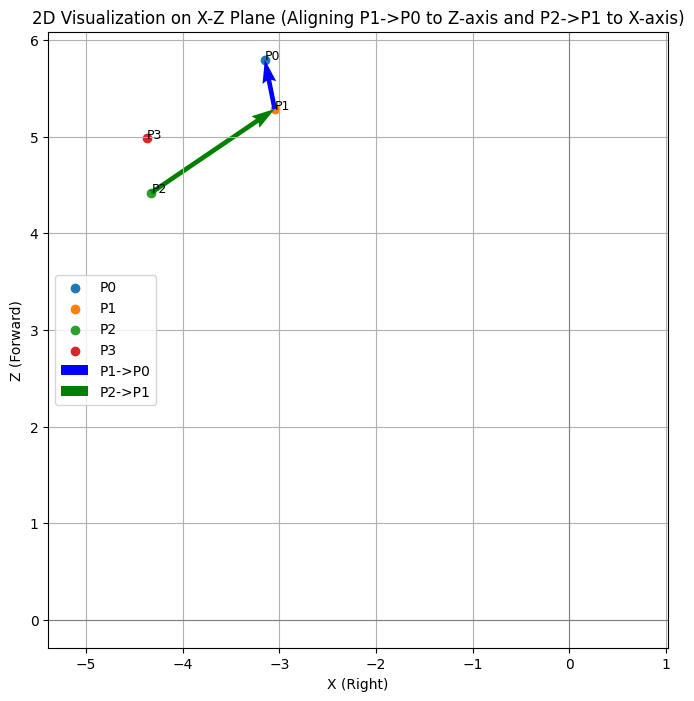

Vector P1->P0: [-0.1023  0.51  ]
Rotation Angle (radians) to align P1->P0 with Z-axis: -0.1979611066734218
Rotation Angle (degrees) to align P1->P0 with Z-axis: -11.342335920126144
Vector P2->P1: [1.2775 0.8665]
Rotation Angle (radians) to align P2->P1 with X-axis: -0.5959981208822565
Rotation Angle (degrees) to align P2->P1 with X-axis: -34.14817692428115


In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Input coordinates (X and Z components)
points_xz = np.array([
    [-3.1509, 5.7967],  # P0
    [-3.0486, 5.2867],  # P1
    [-4.3261, 4.4202],  # P2
    [-4.3691, 4.9874]   # P3
])

# Calculate the vectors
vec_p1_p0 = points_xz[0] - points_xz[1]  # P1->P0
vec_p2_p1 = points_xz[1] - points_xz[2]  # P2->P1

# Function to calculate angle with a given axis
def calculate_angle(vector, axis):
    cos_theta = np.dot(vector, axis) / np.linalg.norm(vector)  # Cosine of the angle
    angle_radians = np.arccos(cos_theta)  # Angle in radians
    # Determine the direction of the angle (clockwise or counterclockwise)
    cross_product = vector[0] * axis[1] - vector[1] * axis[0]  # 2D cross product scalar
    if cross_product < 0:  # Negative cross product means clockwise
        angle_radians = -angle_radians
    return angle_radians

# Calculate angles
z_axis = np.array([0, 1])  # Z-axis in the X-Z plane
x_axis = np.array([1, 0])  # X-axis in the X-Z plane

angle_radians_p1_p0 = calculate_angle(vec_p1_p0, z_axis)  # Align P1->P0 with Z-axis
angle_radians_p2_p1 = calculate_angle(vec_p2_p1, x_axis)  # Align P2->P1 with X-axis

# Visualization
plt.figure(figsize=(8, 8))

# Plot the points
for i, point in enumerate(points_xz):
    plt.scatter(point[0], point[1], label=f"P{i}")
    plt.text(point[0], point[1], f"P{i}", fontsize=9)

# Plot the vectors
plt.quiver(points_xz[1, 0], points_xz[1, 1], vec_p1_p0[0], vec_p1_p0[1], angles='xy', scale_units='xy', scale=1, color='b', label="P1->P0")
plt.quiver(points_xz[2, 0], points_xz[2, 1], vec_p2_p1[0], vec_p2_p1[1], angles='xy', scale_units='xy', scale=1, color='g', label="P2->P1")

# Add axis lines
plt.axhline(0, color='gray', linewidth=0.8)
plt.axvline(0, color='gray', linewidth=0.8)

# Set labels and title
plt.xlabel("X (Right)")
plt.ylabel("Z (Forward)")
plt.title("2D Visualization on X-Z Plane (Aligning P1->P0 to Z-axis and P2->P1 to X-axis)")
plt.legend()
plt.grid()
plt.axis('equal')  # Keep proportions equal
plt.show()

# Print results
print("Vector P1->P0:", vec_p1_p0)
print("Rotation Angle (radians) to align P1->P0 with Z-axis:", angle_radians_p1_p0)
print("Rotation Angle (degrees) to align P1->P0 with Z-axis:", np.degrees(angle_radians_p1_p0))
print("Vector P2->P1:", vec_p2_p1)
print("Rotation Angle (radians) to align P2->P1 with X-axis:", angle_radians_p2_p1)
print("Rotation Angle (degrees) to align P2->P1 with X-axis:", np.degrees(angle_radians_p2_p1))
